In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib


In [2]:
df = pd.read_csv(r"C:\fili\jupyter_proyectos\iris.csv")

df.head()

,Id,sepal_length,sepal_width,petal_length,petal_width,species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df.info()
df.describe()
# Si tiene columna de especie, ver distribución
if 'species' in df.columns:
    print(df['species'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            150 non-null    int64  
 1   sepal_length  150 non-null    float64
 2   sepal_width   150 non-null    float64
 3   petal_length  150 non-null    float64
 4   petal_width   150 non-null    float64
 5   species       150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


In [4]:
# Si existe la columna 'species' (o similar), la usamos como etiqueta opcional
if 'species' in df.columns:
    y = df['species']
    X = df.drop(columns=['species'])
else:
    y = None
    X = df.copy()

X.head()


,Id,sepal_length,sepal_width,petal_length,petal_width
0,1,5.1,3.5,1.4,0.2
1,2,4.9,3.0,1.4,0.2
2,3,4.7,3.2,1.3,0.2
3,4,4.6,3.1,1.5,0.2
4,5,5.0,3.6,1.4,0.2


In [5]:
numeric_cols = X.select_dtypes(include=[np.number]).columns
print("Columnas usadas para PCA:", list(numeric_cols))

X_num = X[numeric_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

X_scaled[:5]


Columnas usadas para PCA: ['Id', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']


array([[-1.72054204, -0.90068117,  1.03205722, -1.3412724 , -1.31297673],
       [-1.69744751, -1.14301691, -0.1249576 , -1.3412724 , -1.31297673],
       [-1.67435299, -1.38535265,  0.33784833, -1.39813811, -1.31297673],
       [-1.65125846, -1.50652052,  0.10644536, -1.2844067 , -1.31297673],
       [-1.62816394, -1.02184904,  1.26346019, -1.3412724 , -1.31297673]])

In [6]:
pca_full = PCA()
pca_full.fit(X_scaled)

explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print("Varianza explicada por componente:")
for i, (ev, cv) in enumerate(zip(explained_var, cumulative_var), start=1):
    print(f"Componente {i}: {ev:.4f}  |  Acumulada: {cv:.4f}")


Varianza explicada por componente:
Componente 1: 0.7471  |  Acumulada: 0.7471
Componente 2: 0.1844  |  Acumulada: 0.9314
Componente 3: 0.0468  |  Acumulada: 0.9782
Componente 4: 0.0176  |  Acumulada: 0.9959
Componente 5: 0.0041  |  Acumulada: 1.0000


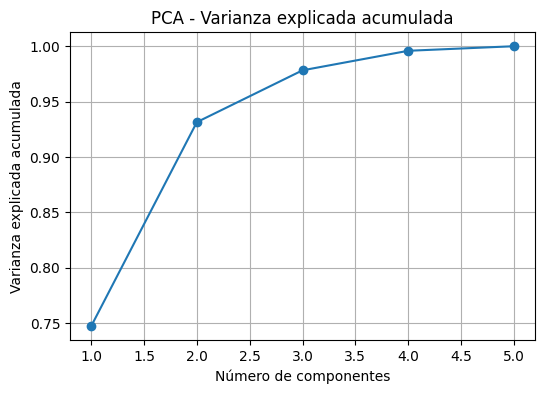

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("PCA - Varianza explicada acumulada")
plt.grid(True)
plt.show()


In [8]:
n_components = 2  # valor elegido para la reducción de dimensionalidad

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print("Shape original:", X_scaled.shape)
print("Shape reducido:", X_pca.shape)

# DataFrame con componentes
df_pca = pd.DataFrame(
    X_pca,
    columns=[f"PCA{i+1}" for i in range(n_components)]
)

if y is not None:
    df_pca['species'] = y.values

df_pca.head()


Shape original: (150, 5)
Shape reducido: (150, 2)


,PCA1,PCA2,species
0,-2.816339,0.506051,Iris-setosa
1,-2.645527,-0.651799,Iris-setosa
2,-2.879481,-0.321036,Iris-setosa
3,-2.810934,-0.577363,Iris-setosa
4,-2.879884,0.670468,Iris-setosa


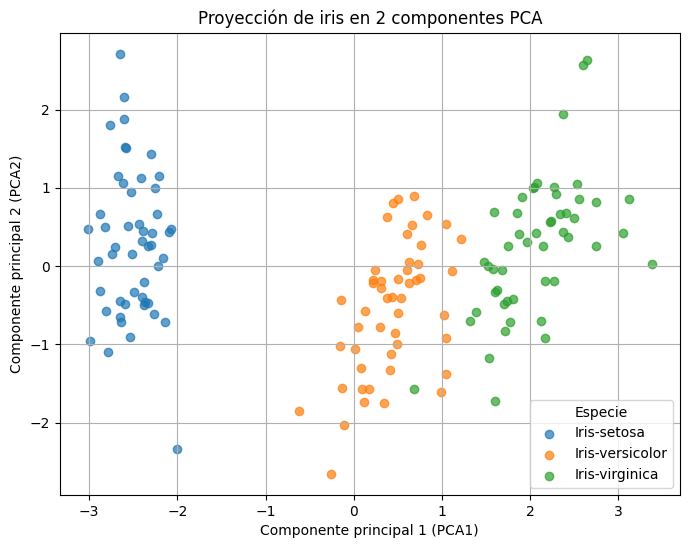

In [9]:
plt.figure(figsize=(8, 6))

if y is not None:
    clases = df_pca['species'].unique()
    for c in clases:
        subset = df_pca[df_pca['species'] == c]
        plt.scatter(
            subset['PCA1'],
            subset['PCA2'],
            label=str(c),
            alpha=0.7
        )
    plt.legend(title="Especie")
else:
    plt.scatter(df_pca['PCA1'], df_pca['PCA2'], alpha=0.7)

plt.xlabel("Componente principal 1 (PCA1)")
plt.ylabel("Componente principal 2 (PCA2)")
plt.title("Proyección de iris en 2 componentes PCA")
plt.grid(True)
plt.show()


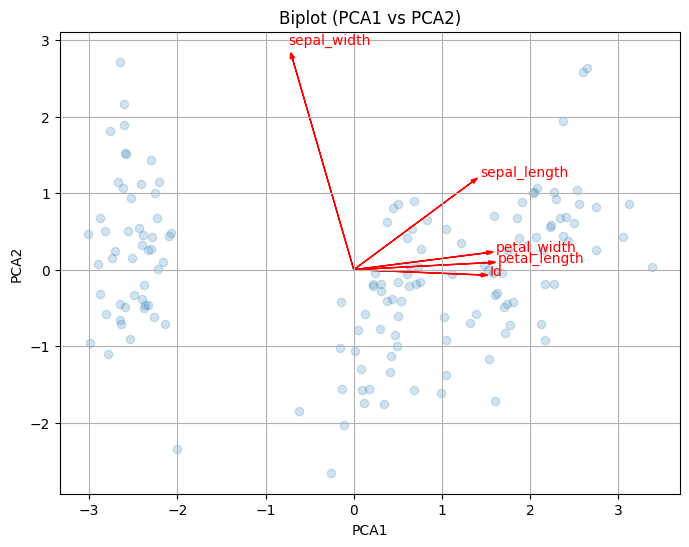

In [10]:
# Cargas de las variables originales en los componentes
loadings = pca.components_.T  # shape: n_features x n_components

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)

for i, feature in enumerate(numeric_cols):
    plt.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3,
              head_width=0.05, color='r')
    plt.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature, color='r')

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Biplot (PCA1 vs PCA2)")
plt.grid(True)
plt.show()


In [11]:
modelo_pca_iris = {
    "scaler": scaler,
    "pca": pca,
    "numeric_cols": list(numeric_cols),
    "n_components": n_components
}

joblib.dump(modelo_pca_iris, "modelo_pca_iris.pkl")

print("Modelo de PCA guardado como 'modelo_pca_iris.pkl'")


Modelo de PCA guardado como 'modelo_pca_iris.pkl'
